### An Audio Version of MNIST Dataset

In [1]:
import numpy as np
import IPython.display as i_dis
import os
import librosa
import librosa.display as display
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 300



import tensorflow as tf
import sklearn
import tensorflow.keras as keras
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

MAIN_DIR = "/home/deadpool/github/MNIST-AUDIO-CLASSIFICATION/"
DATA_DIR = os.path.join(MAIN_DIR,"mnist spoken data","recordings")
SAMPLE_DIR = os.path.join(MAIN_DIR,"samples")
LABELS = ["ZERO","ONE","TWO","THREE","FOUR","FIVE","SIX","SEVEN","EIGHT","NINE"]
LENGTH = 9000
SAMPLE_RATE = 8000 #Hz
# os.makedirs("Figures",exist_ok=True)
# FIG_DIR = os.path.join(MAIN_DIR,"Figures")
# print(MAIN_DIR)

In [2]:
os.chdir(DATA_DIR)
print("Play a sample wavfile from the datset:")
i_dis.Audio("0_theo_4.wav")

Play a sample wavfile from the datset:


### Prepare Dataset

In [3]:
def fetch_data(length=LENGTH):
    audio = []
    labels = []
    for file in os.listdir():
        
        a, SR = librosa.load(file,sr=None)
        a, index = librosa.effects.trim(a,top_db=20,frame_length=256, hop_length=64)
        if(len(a)>length or len(a)<2000):
            continue
        elif(len(a)<length):
            a = np.pad(a,(0,length-len(a)),constant_values=(0,0))
        audio.append(a)
        labels.append(file[0])
    return audio,SR,labels

In [4]:
audios, SR, labels = fetch_data(length=4000)

In [5]:
sample_len = [len(x) for x in audios]

In [6]:
print(SR)
print(len(audios))

8000
1228


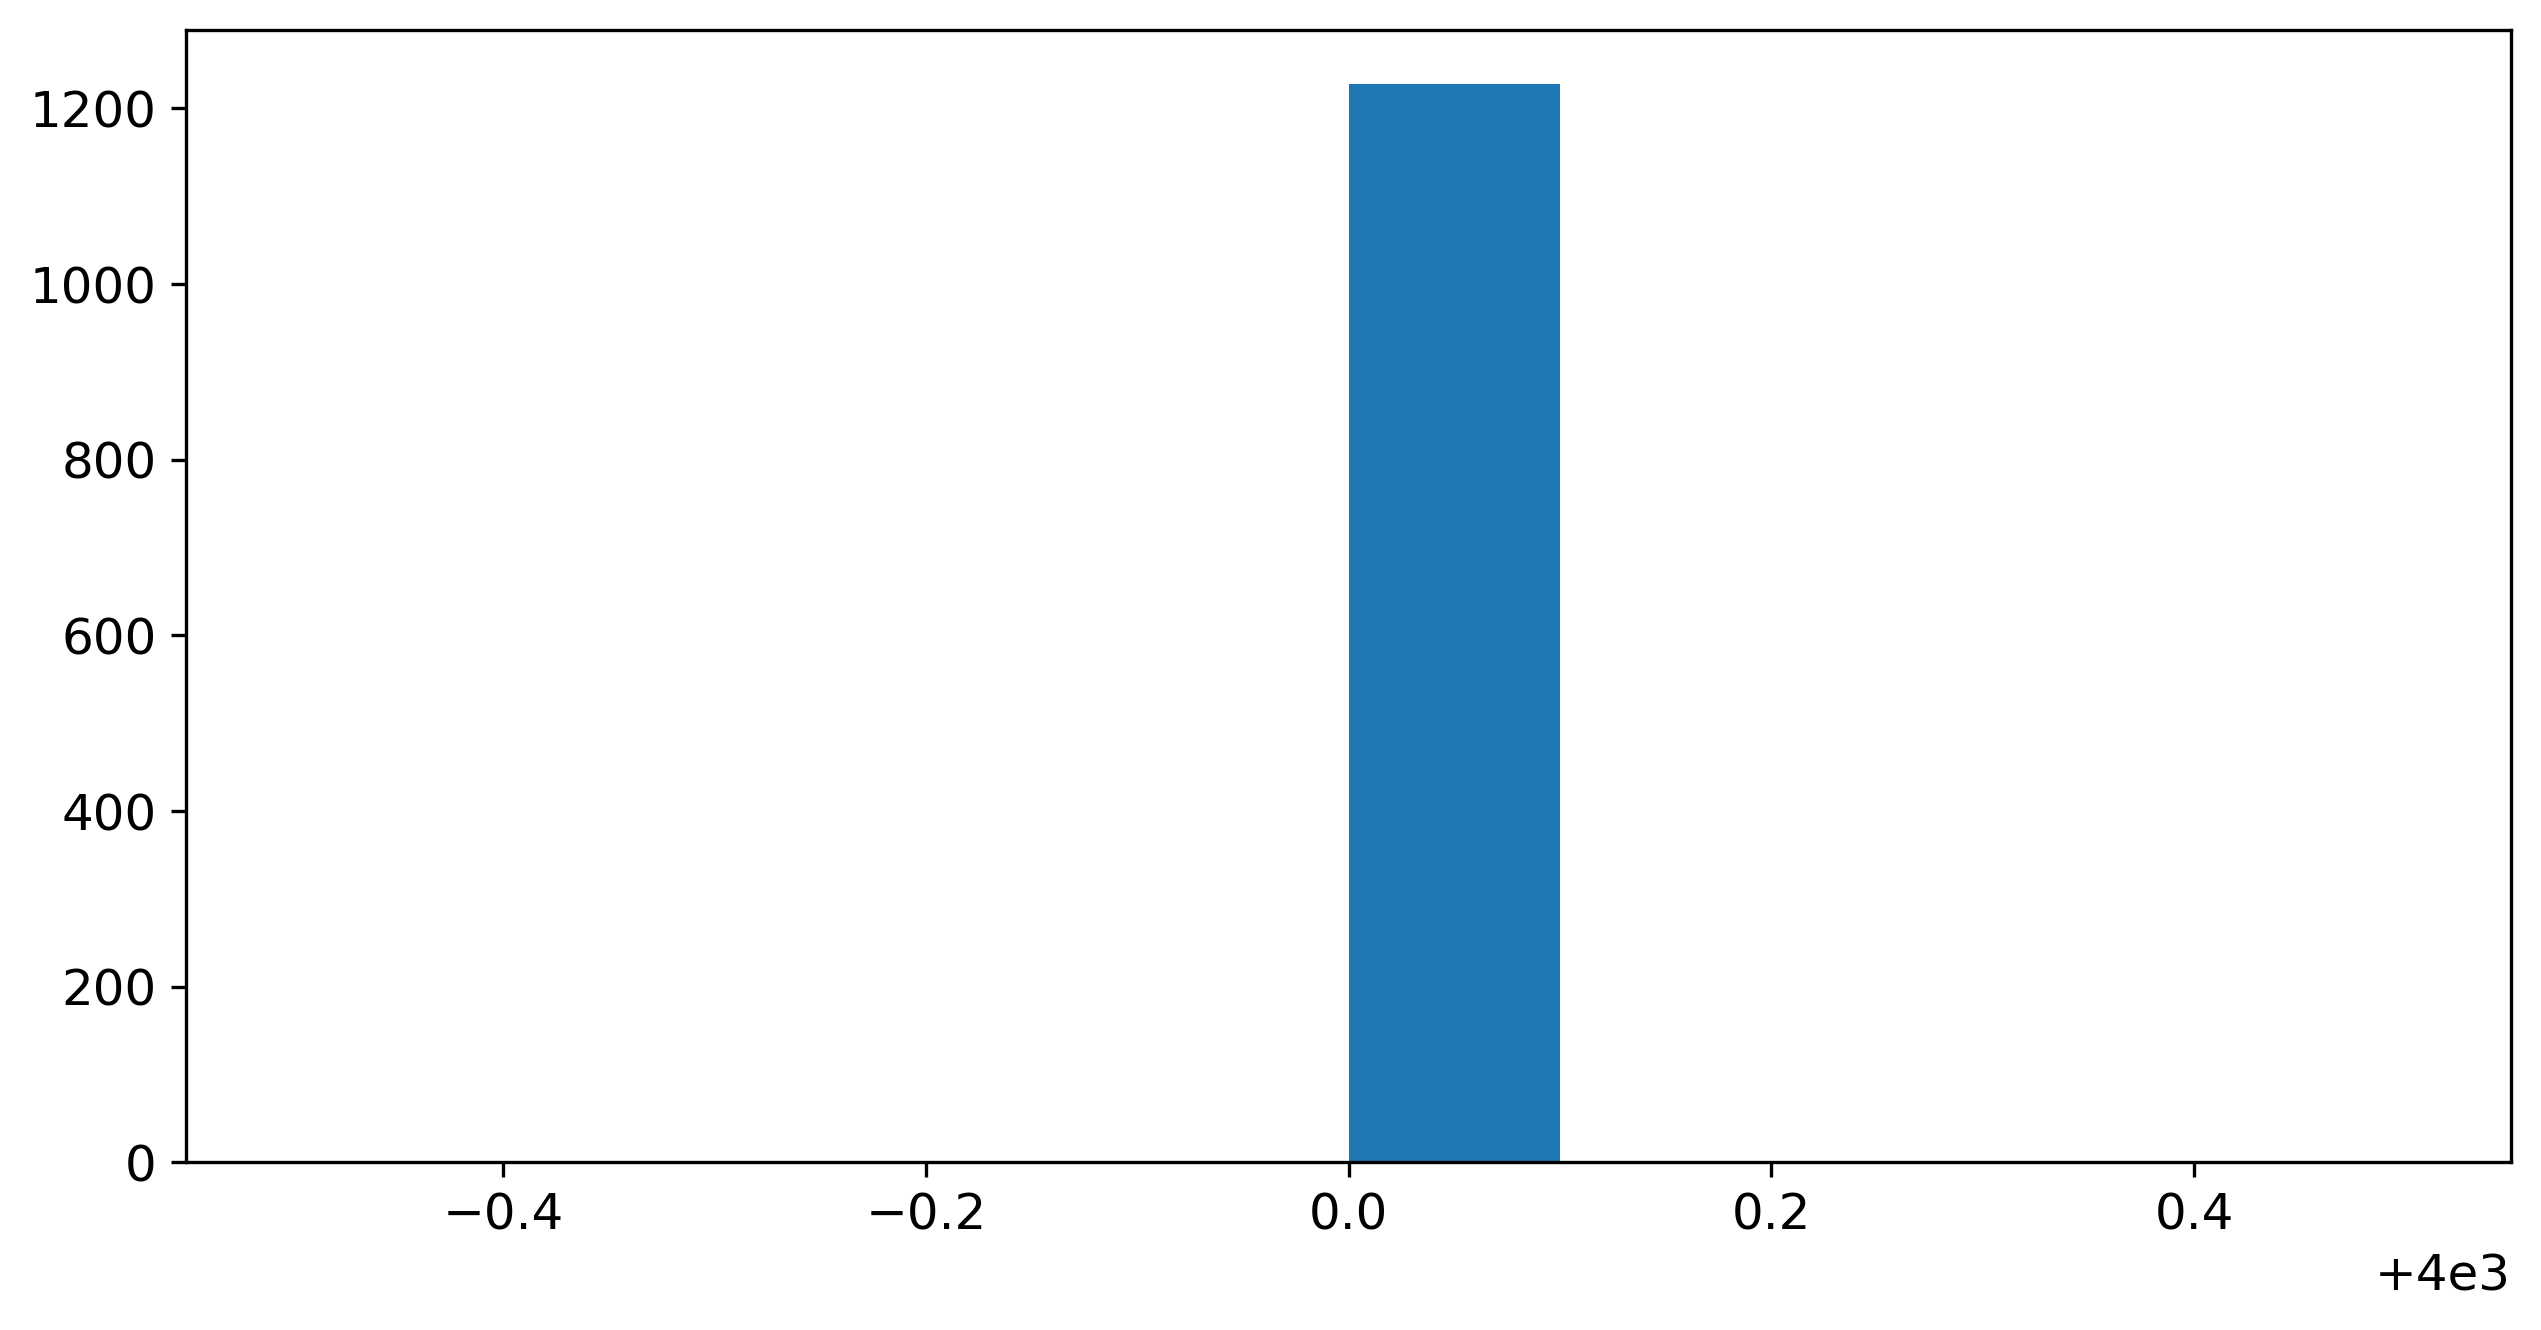

In [7]:
plt.hist(sample_len)
plt.show()

In [9]:
np.percentile(sample_len,91)

4000.0

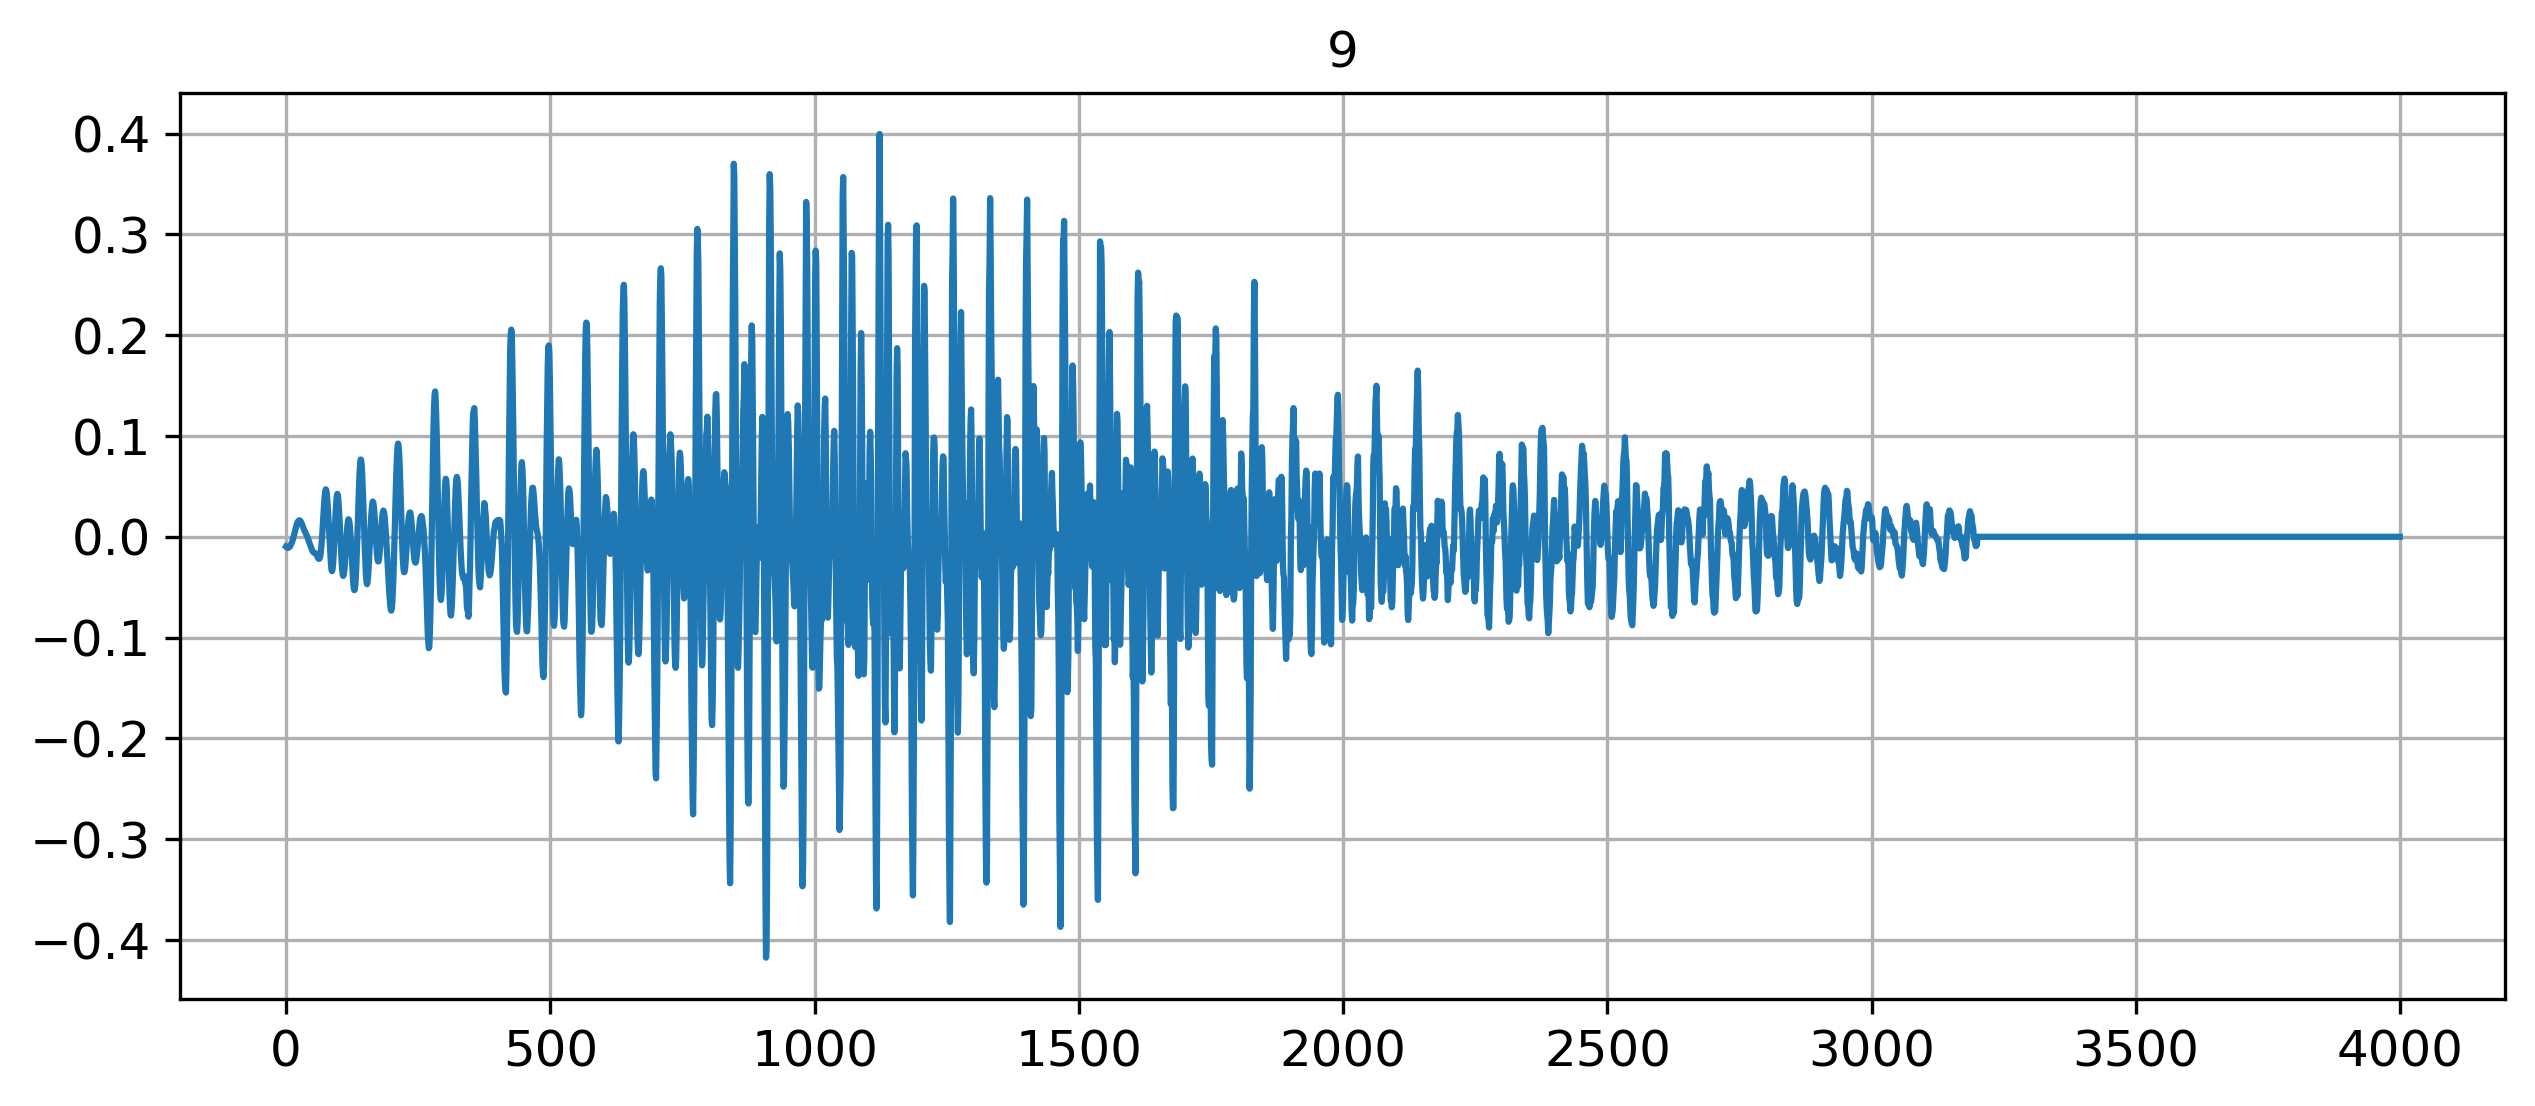

In [10]:
# librosa.display.waveplot(audios[0],sr=SR)
plt.figure(figsize=(10,4))
plt.title(labels[0])
plt.plot(audios[1000])
plt.grid("ON")
plt.show()

In [11]:
mfcc = librosa.feature.mfcc(audios[0],sr=SR,n_mfcc=15,hop_length=125,n_fft=512)

[Text(0.5, 1.0, 'MFCC')]

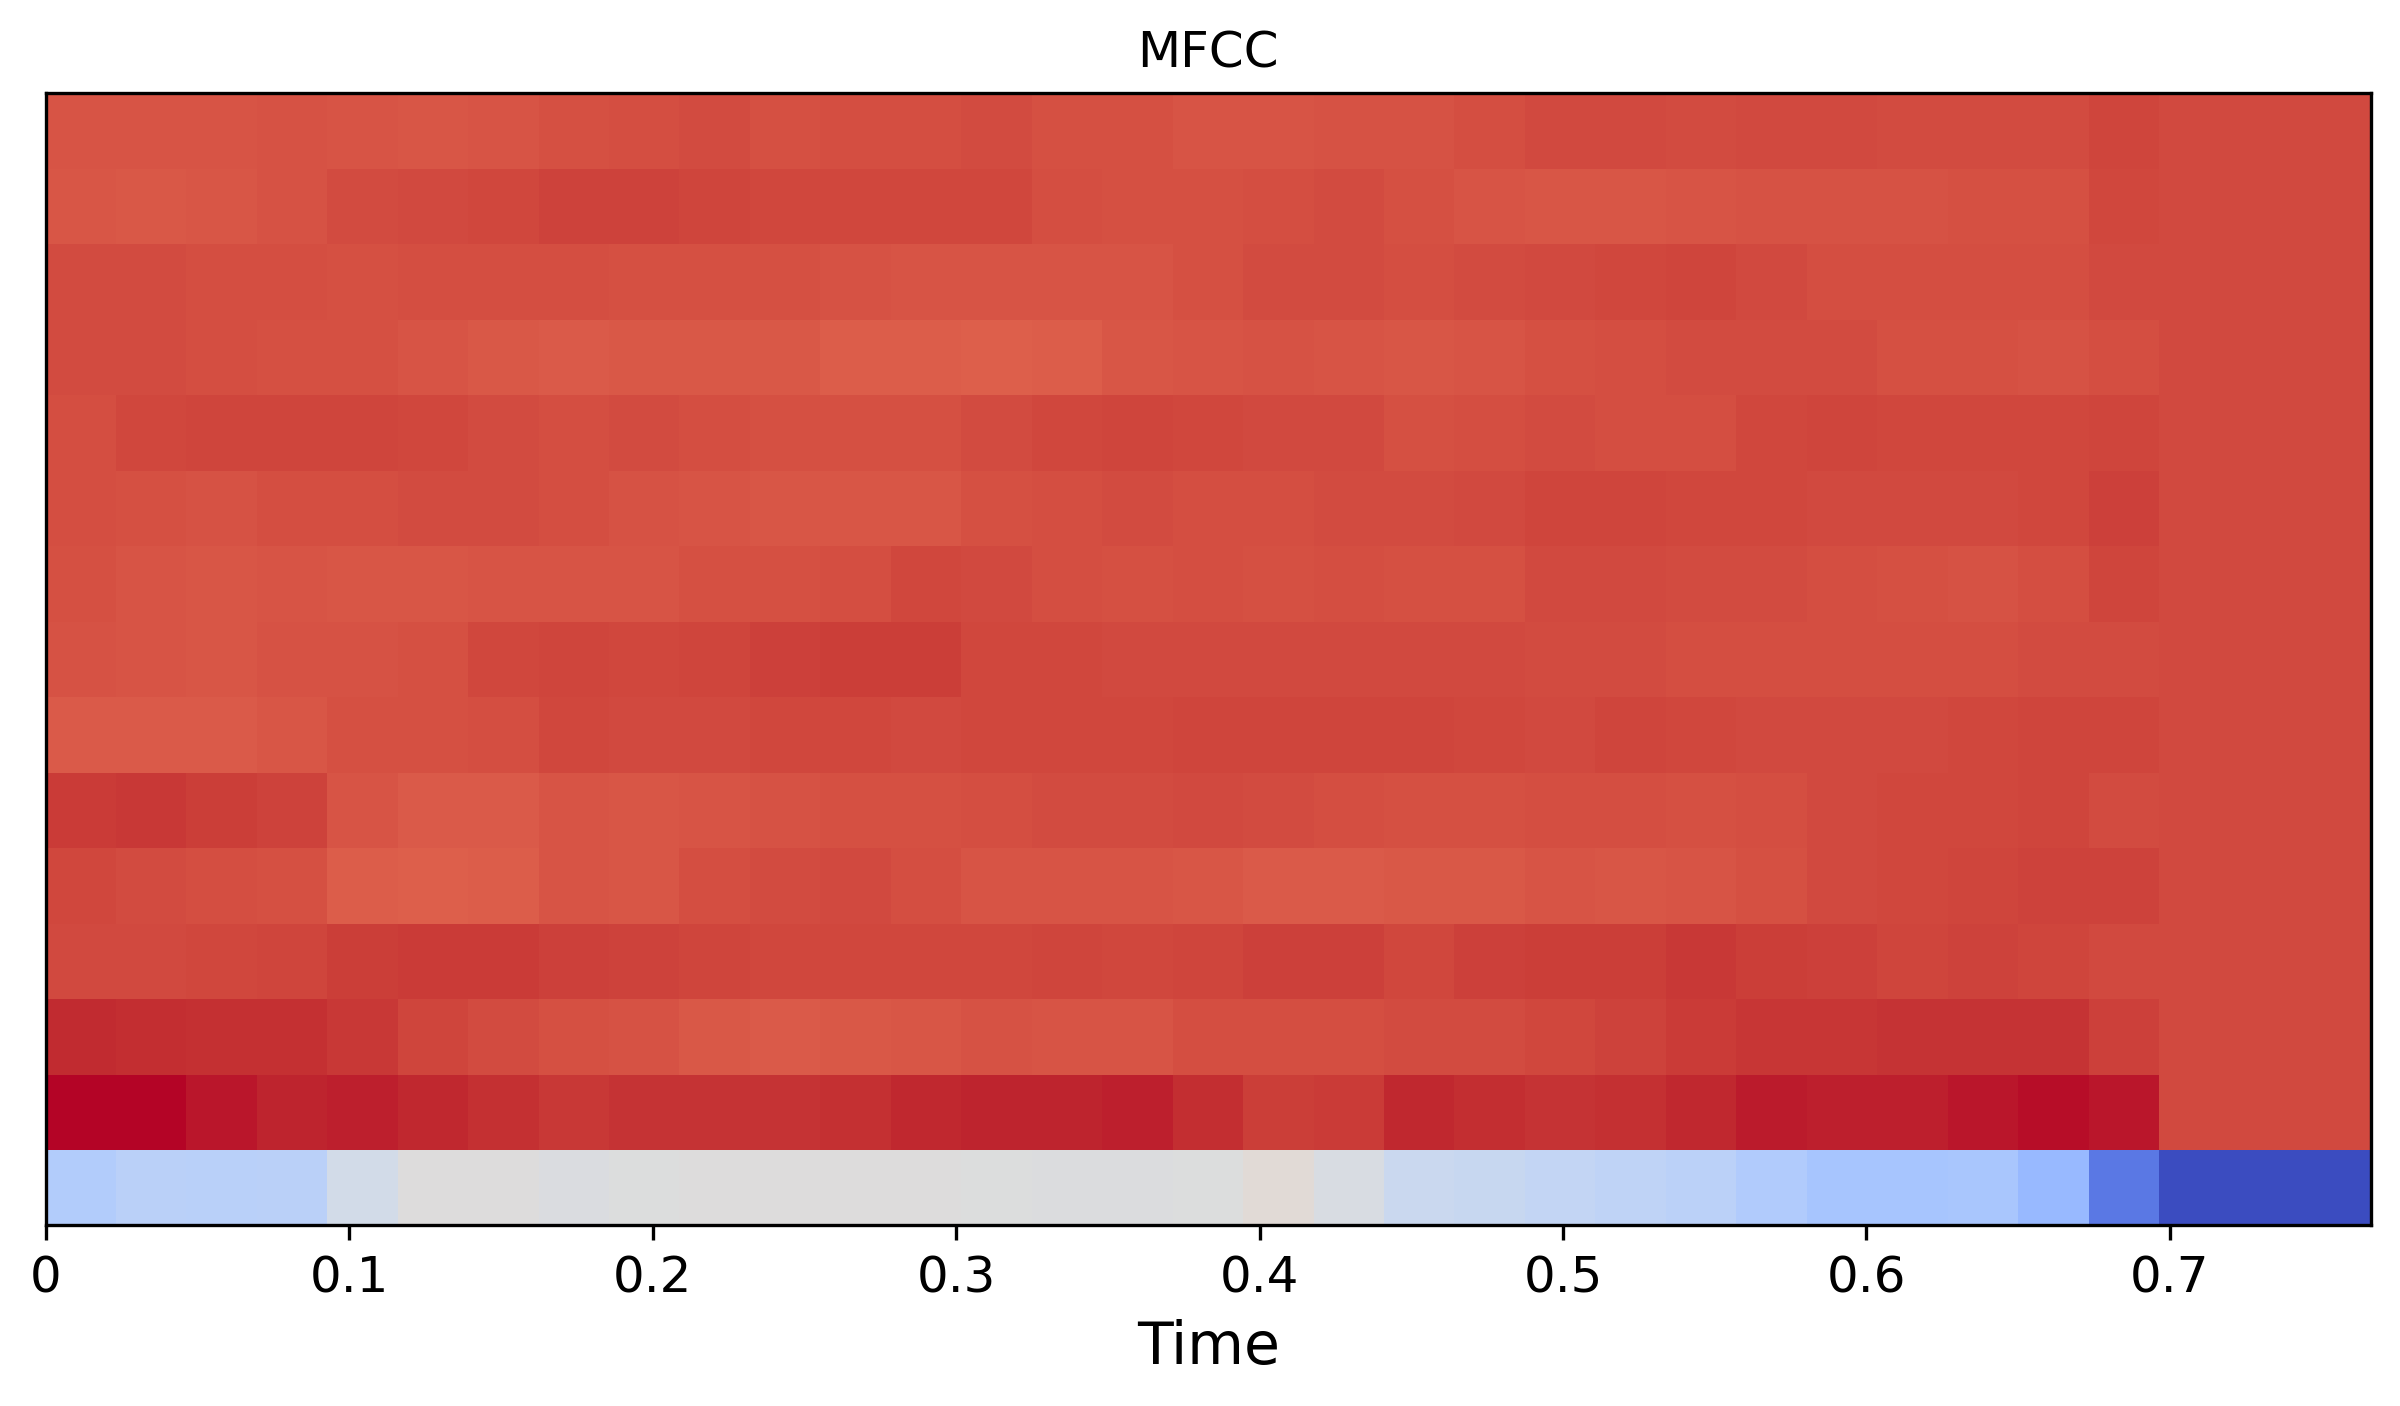

In [12]:
fig, ax = plt.subplots()
img = display.specshow(mfcc, x_axis='time', ax=ax)
# fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [14]:
mfcc.shape

(15, 33)

In [15]:
import pandas as pd

In [16]:
data = pd.Series(labels)

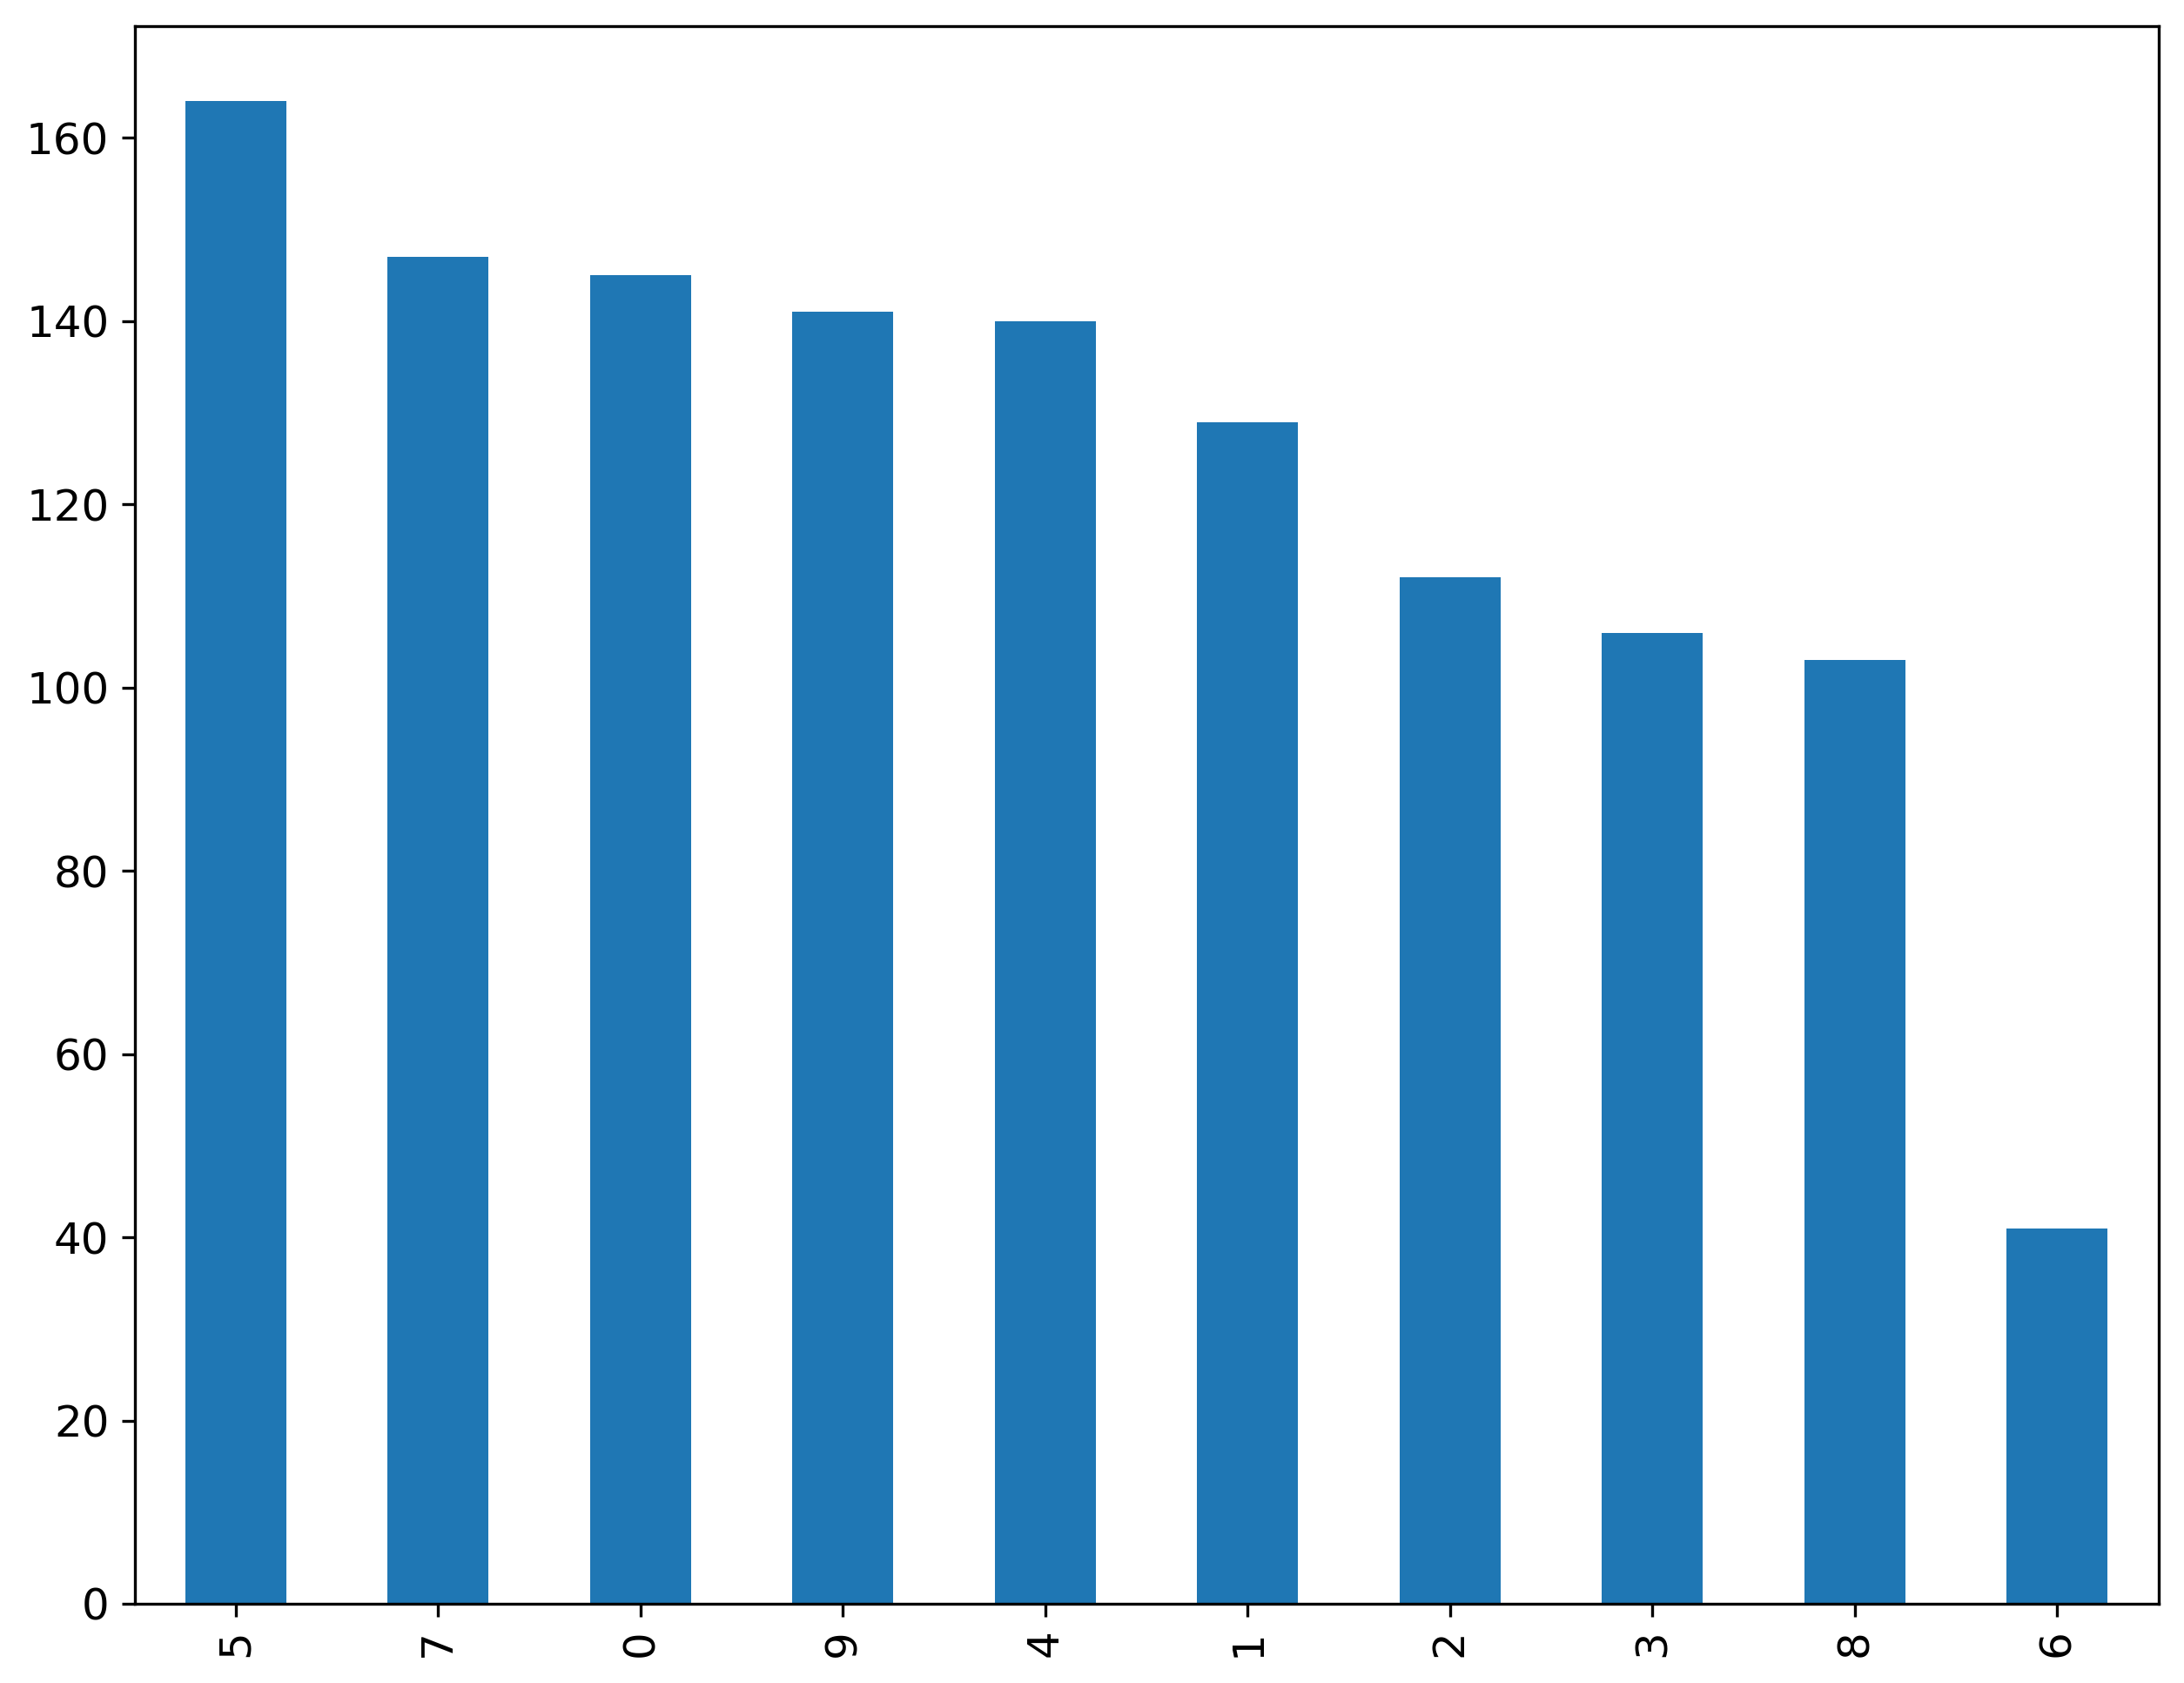

In [17]:
plt.figure(figsize=(10,8))
data.value_counts().plot(kind="bar")
plt.show()

### Data Augmentation

### NOISE ADDITION

In [ ]:
def add_noise(data, FACTOR=0.003):
    noise = np.random.randn(len(data))
    new_data = data + FACTOR * noise
    return new_data.astype(type(data[0]))
    

In [ ]:
new_audios_noise = np.array(list(map(add_noise,audios)))

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(audios[0])
plt.plot(new_audios_noise[0],alpha=0.4)
plt.show()

In [ ]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [ ]:
# manipulated audio
i_dis.Audio(new_audios_noise[0],rate=8000)

### TIME SHIFTING

In [ ]:
def time_shift(data,SHIFT_LEN=300,SHIFT_DIR ="RIGHT"):
    if SHIFT_DIR != "RIGHT":
        SHIFT_LEN = - SHIFT_LEN
    shifted_data = np.roll(data,SHIFT_LEN)
    if SHIFT_LEN>0:
        shifted_data[:SHIFT_LEN] = 0
    else:
        shifted_data[SHIFT_LEN:] = 0
    return shifted_data

In [ ]:
new_audios_shifted = np.array(list(map(lambda x: time_shift(x,SHIFT_DIR="LEFT"),audios)))

In [ ]:
plt.plot(new_audios_shifted[0])
plt.plot(audios[0],alpha=0.7)
plt.show()

In [ ]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [ ]:
# original audio
i_dis.Audio(new_audios_shifted[0],rate=8000)

### CHANGING PITCH

In [ ]:
def change_pitch(data,sr=8000,FACTOR=0.1):
    return librosa.effects.pitch_shift(data,SR,FACTOR)

In [ ]:
new_audios_pitch = np.array(list(map(change_pitch,audios)))

plt.plot(new_audios_pitch[0])
plt.plot(audios[0],alpha=0.7)
plt.show()

In [ ]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [ ]:
# manipulated audio
i_dis.Audio(new_audios_pitch[0],rate=8000)

### CHANGING SPEED

In [ ]:
def change_speed(data,RATE=0.5):
    """
    change speed of the given sample
    if rate < 0 --> audio becomes slower
    if rate > 0 --> audio becomes faster
    """
    return librosa.effects.time_stretch(data,RATE)

In [ ]:
new_audios_speed = np.array(list(map(change_speed,audios)))

In [ ]:
plt.plot(new_audios_speed[0])
plt.plot(audios[0],alpha=0.7)
plt.show()

In [ ]:
# original audio
i_dis.Audio(audios[0],rate=8000)

In [ ]:
# manipulated audio
i_dis.Audio(new_audios_speed[0],rate=8000)

In [ ]:
len(new_audios_speed[0])

### Extract Features

In [18]:
def extract_MFCC(audio,SR,n_mfcc=20,hop_length=125,n_fft=256):
    features = []
    for a,index in zip(audio,tqdm.tqdm( range(len(audio)),desc="Extracting Features: ")):
        mfcc = librosa.feature.mfcc(a,sr=SR,n_mfcc=n_mfcc,hop_length=hop_length,n_fft=n_fft)
        features.append(mfcc.T)
    return features

In [19]:
features = extract_MFCC(audios,SR)

Extracting Features: 100%|█████████▉| 1227/1228 [00:07<00:00, 155.00it/s]


In [20]:
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels).astype('float64')

In [21]:
X = np.array(features)
Y = encoded_labels

In [22]:
splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.1, random_state=42)

train_id, test_id = next(splitter.split(X,Y))
X_train,y_train,X_test,y_test = X[train_id],Y[train_id],X[test_id],Y[test_id]

train_id, test_id = next(splitter.split(X_train,y_train))
X_train,y_train,X_val,y_val = X_train[train_id],y_train[train_id],X_train[test_id],y_train[test_id]

In [23]:
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
X_val = X_val[..., np.newaxis]

INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1)

In [24]:
print(X_train[0].shape)
print(X_train.shape)
print(X_test.shape)

(33, 20, 1)
(994, 33, 20, 1)
(123, 33, 20, 1)


In [34]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",input_shape=INPUT_SHAPE,kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

# 3rd conv layer
model.add(tf.keras.layers.Conv2D(32, (2, 2), activation='relu',
                                 kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

# flatten output and feed into dense layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
tf.keras.layers.Dropout(0.3)

# softmax output layer
model.add(tf.keras.layers.Dense(10, activation='softmax'))


In [35]:
model.compile(optimizer="Adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 31, 18, 64)        640       
_________________________________________________________________
batch_normalization_3 (Batch (None, 31, 18, 64)        256       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 9, 64)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 7, 32)         18464     
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 7, 32)         128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 4, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 3, 32)         

In [37]:
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=5)

In [38]:
history = model.fit(X_train,y_train,epochs=30,batch_size=30,validation_data=(X_val,y_val),callbacks=[earlystop_callback])

Epoch 1/30
34/34 [==============================] - 2s 45ms/step - loss: 1.8292 - accuracy: 0.4155 - val_loss: 2.8057 - val_accuracy: 0.2432
Epoch 2/30
34/34 [==============================] - 1s 43ms/step - loss: 0.7488 - accuracy: 0.8300 - val_loss: 1.2351 - val_accuracy: 0.6306
Epoch 3/30
34/34 [==============================] - 1s 39ms/step - loss: 0.4046 - accuracy: 0.9256 - val_loss: 0.9692 - val_accuracy: 0.6667
Epoch 4/30
34/34 [==============================] - 1s 39ms/step - loss: 0.2103 - accuracy: 0.9769 - val_loss: 0.5526 - val_accuracy: 0.8829
Epoch 5/30
34/34 [==============================] - 1s 40ms/step - loss: 0.1450 - accuracy: 0.9920 - val_loss: 0.3322 - val_accuracy: 0.9369
Epoch 6/30
34/34 [==============================] - 1s 39ms/step - loss: 0.1184 - accuracy: 0.9950 - val_loss: 0.3210 - val_accuracy: 0.9459
Epoch 7/30
34/34 [==============================] - 1s 40ms/step - loss: 0.1245 - accuracy: 0.9909 - val_loss: 0.2906 - val_accuracy: 0.9459
Epoch 8/30
34

In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

4/4 [==============================] - 0s 12ms/step - loss: 0.1841 - accuracy: 0.9593

Test loss: 0.1840505748987198, test accuracy: 95.93495726585388


In [40]:
os.chdir(SAMPLE_DIR)

In [41]:
i_dis.Audio("0_rabin_0.wav")

In [42]:
sample,gan = librosa.load("0_rabin_0.wav",sr=None)

In [ ]:
len(sample)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(sample)
plt.grid("ON")
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
off = int(len(sample)/2)
# sample =sample[:4000]
plt.plot(trimmed[:4000])
plt.grid("ON")
plt.show()

In [ ]:
trimmed, index = librosa.effects.trim(sample,top_db=10,frame_length=256, hop_length=64)

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(trimmed)
plt.grid("ON")
plt.show()

In [ ]:
len(trimmed)

In [ ]:
index

In [ ]:
mfcc = librosa.feature.mfcc(sample[:4000],sr=gan,n_mfcc=13,hop_length=256,n_fft=2048)

In [ ]:
mfcc.shape

In [ ]:
mfcc = mfcc[...,np.newaxis]

In [ ]:
mfcc = mfcc[np.newaxis,...]

In [ ]:
mfcc.shape

In [ ]:
model.predict_classes(mfcc)

In [43]:
real_data = []
real_labels = []
LENGTH = 4000
THRESHOLD = 2000

for file in os.listdir():
    sample,sr = librosa.load(file,sr=None)
    sample, index = librosa.effects.trim(sample,top_db=15,frame_length=256, hop_length=64)
    if(len(sample)>LENGTH):
        sample = sample[:LENGTH]
    if(len(sample)<THRESHOLD):
        print("Corrupt file")
        continue
    if(len(sample)<LENGTH):
        sample = np.pad(sample,(0,LENGTH-len(sample)),constant_values=(0,0))
    mfcc = librosa.feature.mfcc(sample,sr=sr,n_mfcc=20,hop_length=125,n_fft=256)
    real_data.append(mfcc.T)
    real_labels.append(float(file[0]))
    mfcc = mfcc.T[np.newaxis,...,np.newaxis]
    p = model.predict_classes(mfcc)
    print(int(p), end="   ")
    print(file[0])

print(len(real_data))
print(type(real_data))

real_data =np.array(real_data)
real_labels = np.array(real_labels)
real_data = real_data[...,np.newaxis]
model.evaluate(real_data,real_labels)

3   0
1   9
2   6
9   7
Corrupt file
3   3
9   7
3   0
1   1
Corrupt file
3   3
Corrupt file
3   6
3   8
Corrupt file
1   5
3   5
9   9
1   1
1   5
Corrupt file
Corrupt file
3   6
3   9
3   0
3   7
Corrupt file
1   4
3   3
1   1
23
<class 'list'>
1/1 [==============================] - 0s 1ms/step - loss: 2.6004 - accuracy: 0.3043


[2.6004116535186768, 0.30434781312942505]

In [44]:
os.listdir()

['0_rabin_1.wav',
 '9_rabin_0.wav',
 '6_rabin_0.wav',
 '7_rabin_2.wav',
 '2_rabin_0.wav',
 '3_rabin_2.wav',
 '7_rabin_1.wav',
 '0_rabin_0.wav',
 '1_rabin_1.wav',
 '8_rabin_0.wav',
 '3_rabin_1.wav',
 '8_rabin_2.wav',
 '6_rabin_1.wav',
 '8_rabin_1.wav',
 '2_rabin_1.wav',
 '5_rabin_2.wav',
 '5_rabin_0.wav',
 '9_rabin_2.wav',
 '1_rabin_2.wav',
 '5_rabin_1.wav',
 '4_rabin_1.wav',
 '2_rabin_2.wav',
 '6_rabin_2.wav',
 '9_rabin_1.wav',
 '0_rabin_2.wav',
 '7_rabin_0.wav',
 '4_rabin_2.wav',
 '4_rabin_0.wav',
 '3_rabin_0.wav',
 '1_rabin_0.wav']

In [45]:
print(real_labels)

[0. 9. 6. 7. 3. 7. 0. 1. 3. 6. 8. 5. 5. 9. 1. 5. 6. 9. 0. 7. 4. 3. 1.]


In [46]:
model.predict_classes(real_data)

array([3, 1, 2, 9, 3, 9, 3, 1, 3, 3, 3, 1, 3, 9, 1, 1, 3, 3, 3, 3, 1, 3,
       1])

In [ ]:
model.predict_classes(real_data[0][np.newaxis,...])

In [ ]:
real_data[0].shape